# Practical Lab 1: Streaming Data for Predictive Maintenance with Linear Regression-Based Alerts

## Overview
This notebook implements a predictive maintenance system for industrial current data (axes 1-8). It:
- Connects to a Neon.tech PostgreSQL database to pull training data.
- Fits linear regression models (Time → Axis values) for axes 1-8.
- Analyzes residuals to discover alert/error thresholds (MinC, MaxC, T).
- Generates synthetic test data to simulate streaming.
- Detects alerts/errors based on thresholds and logs events.
- Visualizes regression fits, residuals, and annotated alerts/errors.

The goal is to detect anomalies in current data to flag potential failures early, using evidence-based thresholds.

## Load Environment and Connect to Database
Pull training data from Neon.tech PostgreSQL, convert time to numeric, and export to CSV.

In [1]:
import os
import pandas as pd
from dotenv import load_dotenv
from sqlalchemy import create_engine

# Load .env file
load_dotenv()

PGHOST = os.getenv('PGHOST')
PGPORT = os.getenv('PGPORT', '5432')
PGDATABASE = os.getenv('PGDATABASE')
PGUSER = os.getenv('PGUSER')
PGPASSWORD = os.getenv('PGPASSWORD')
PGSSL = os.getenv('PGSSL', 'require')

assert PGHOST and PGDATABASE and PGUSER and PGPASSWORD, '❌ Missing DB env vars. Check your .env file!'

# Build SQLAlchemy engine
engine = create_engine(
    f'postgresql+psycopg2://{PGUSER}:{PGPASSWORD}@{PGHOST}:{PGPORT}/{PGDATABASE}?sslmode={PGSSL}',
    pool_pre_ping=True
)

# Query staging_measurements
query = '''
SELECT time, axis1, axis2, axis3, axis4, axis5, axis6, axis7, axis8
FROM staging_measurements
'''

# Load into DataFrame
df_train = pd.read_sql(query, engine)

# Ensure datetime and sort
df_train['time'] = pd.to_datetime(df_train['time'])
df_train.sort_values('time', inplace=True)

# Convert time to numeric (seconds since start)
df_train['time_numeric'] = (df_train['time'] - df_train['time'].min()).dt.total_seconds()

# Save to CSV
os.makedirs('Data', exist_ok=True)
df_train.to_csv('Data/Training_data.csv', index=False)

print('✅ Data exported from staging_measurements to Data/Training_data.csv')
print(df_train.head())

✅ Data exported from staging_measurements to Data/Training_data.csv
                              time  axis1  axis2  axis3  axis4  axis5  axis6  \
0 2022-10-17 12:18:23.660000+00:00    0.0    0.0    0.0    0.0    0.0    0.0   
1 2022-10-17 12:18:25.472000+00:00    0.0    0.0    0.0    0.0    0.0    0.0   
2 2022-10-17 12:18:27.348000+00:00    0.0    0.0    0.0    0.0    0.0    0.0   
3 2022-10-17 12:18:29.222000+00:00    0.0    0.0    0.0    0.0    0.0    0.0   
4 2022-10-17 12:18:31.117000+00:00    0.0    0.0    0.0    0.0    0.0    0.0   

   axis7  axis8  time_numeric  
0    0.0    0.0         0.000  
1    0.0    0.0         1.812  
2    0.0    0.0         3.688  
3    0.0    0.0         5.562  
4    0.0    0.0         7.457  


## Train Linear Regression Models and Analyze Residuals
Fit univariate regression models (Time → Axes 1-8), compute slopes/intercepts, and analyze residuals.

In [9]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

pd.set_option('display.width', 120)
pd.set_option('display.max_columns', 20)

DATA_DIR = Path('Data')
DATA_DIR.mkdir(parents=True, exist_ok=True)
AXES = ['axis1', 'axis2', 'axis3', 'axis4', 'axis5', 'axis6', 'axis7', 'axis8']

# Load training data
train_path = DATA_DIR / 'Training_data.csv'
assert train_path.exists(), 'Training_data.csv not found. Run DB cell first.'
df_train = pd.read_csv(train_path)
df_train['time'] = pd.to_datetime(df_train['time'], errors='coerce')
df_train = df_train.sort_values('time').reset_index(drop=True)

# Ensure time_numeric
if 'time_numeric' not in df_train.columns:
    df_train['time_numeric'] = (df_train['time'] - df_train['time'].min()).dt.total_seconds()

# Drop missing values
df_train = df_train.dropna(subset=['time_numeric'] + AXES)

# Estimate sampling interval
time_diffs = df_train['time'].diff().dt.total_seconds()
sample_interval_sec = float(np.nanmedian(time_diffs))
print(f'Estimated sampling interval: {sample_interval_sec:.3f} seconds')

# Fit models
models = {}
slopes = {}
intercepts = {}
residuals_dict = {}
X = df_train[['time_numeric']].values

for axis in AXES:
    y = df_train[axis].values.astype(float)
    mdl = LinearRegression()
    mdl.fit(X, y)
    models[axis] = mdl
    slopes[axis] = float(mdl.coef_[0])
    intercepts[axis] = float(mdl.intercept_)
    y_pred = mdl.predict(X)
    residuals_dict[axis] = y - y_pred

# Summaries
model_summary = pd.DataFrame({
    'axis': AXES,
    'slope': [slopes[a] for a in AXES],
    'intercept': [intercepts[a] for a in AXES]
}).sort_values('axis')

# Compute residual stats (mean and std for each axis)
residual_stats = pd.DataFrame({
    'axis': AXES,
    'residual_mean': [float(np.mean(residuals_dict[a])) for a in AXES],
    'residual_std': [float(np.std(residuals_dict[a], ddof=0)) for a in AXES],
}).sort_values('axis').reset_index(drop=True)

# Save artifacts
model_summary.to_csv(DATA_DIR / 'model_params.csv', index=False)
residual_stats.to_csv(DATA_DIR / 'residual_stats.csv', index=False)

print('\n📊 Model parameters (slopes/intercepts):')
print(model_summary)
print('\n📊 Residual stats (mean/std):')
print(residual_stats)
print('\n✅ Ready: models, residuals_dict, model_params.csv, residual_stats.csv')

Estimated sampling interval: 1.891 seconds

📊 Model parameters (slopes/intercepts):
    axis         slope  intercept
0  axis1 -1.176729e-07   0.730542
1  axis2  2.194203e-06   3.523886
2  axis3 -5.777186e-07   2.733898
3  axis4  3.890034e-07   0.604357
4  axis5  8.381178e-08   0.951103
5  axis6  4.744455e-07   0.580077
6  axis7  5.537186e-07   0.847563
7  axis8  8.499989e-08   0.098748

📊 Residual stats (mean/std):
    axis  residual_mean  residual_std
0  axis1  -1.719402e-17      2.162091
1  axis2   2.751043e-16      6.879688
2  axis3  -4.585071e-17      5.111819
3  axis4   9.170142e-17      1.574851
4  axis5  -1.490148e-16      2.100159
5  axis6  -9.743276e-17      1.815442
6  axis7   1.146268e-16      2.166746
7  axis8   1.146268e-17      0.423065

✅ Ready: models, residuals_dict, model_params.csv, residual_stats.csv


## Visualize Regression Fits and Residuals
Plot training data with regression lines and residual distributions to identify patterns.

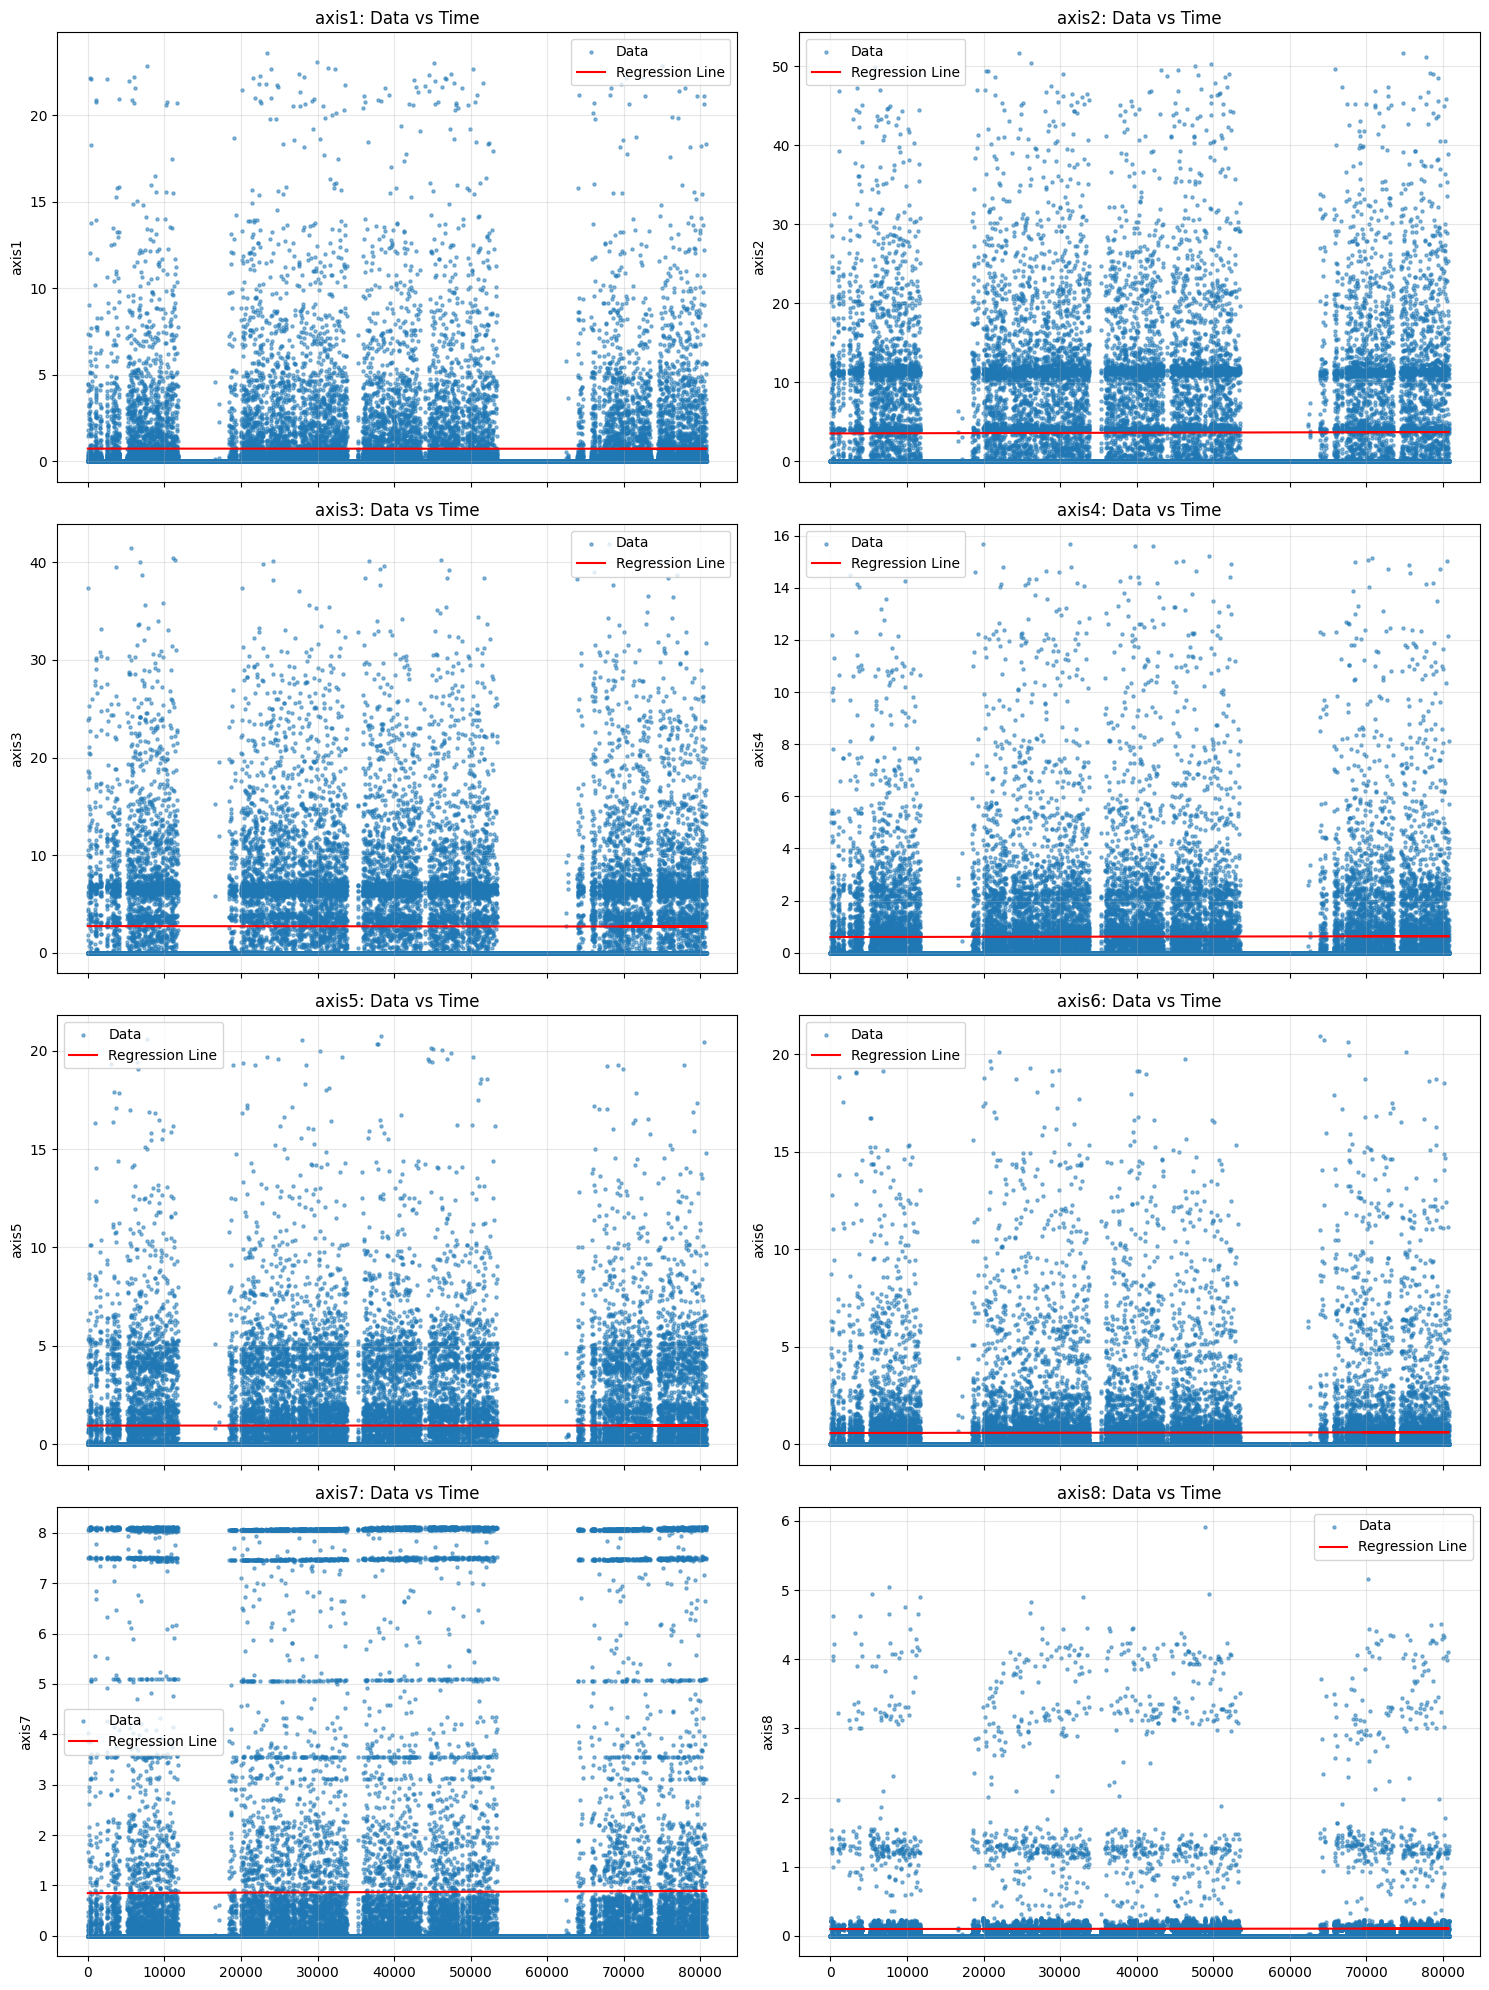

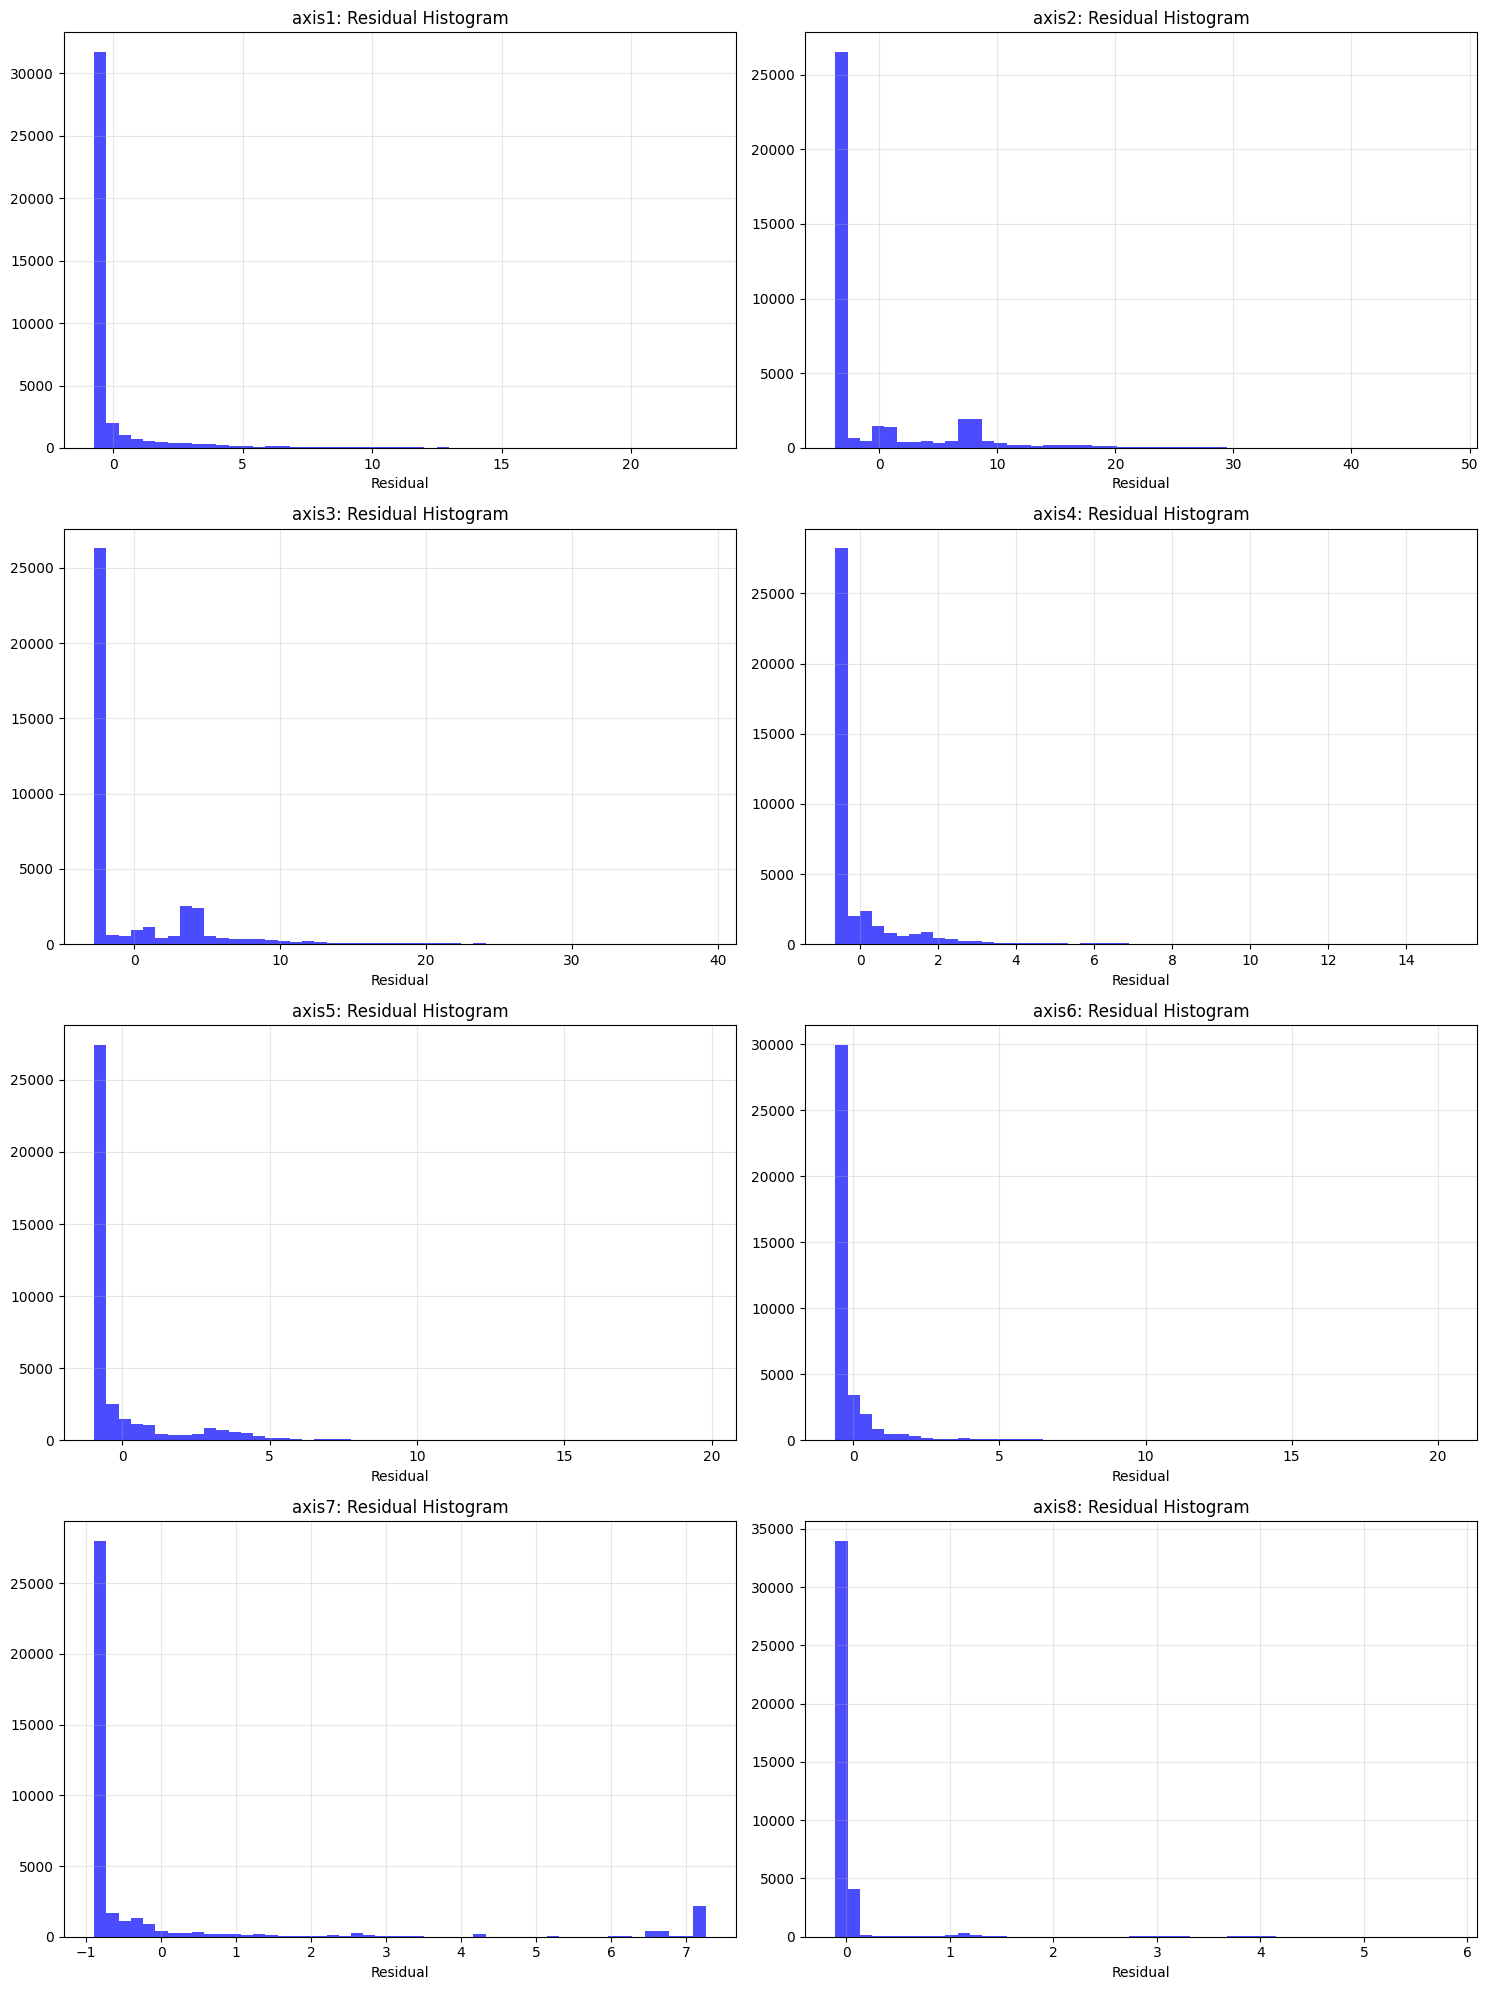

In [10]:
import matplotlib.dates as mdates

# Plot regression lines
fig, axs = plt.subplots(4, 2, figsize=(15, 20), sharex=True)
axs = axs.flatten()
for i, axis in enumerate(AXES):
    axs[i].scatter(df_train['time_numeric'], df_train[axis], s=5, alpha=0.5, label='Data')
    y_pred = models[axis].predict(X)
    axs[i].plot(df_train['time_numeric'], y_pred, color='red', label='Regression Line')
    axs[i].set_title(f'{axis}: Data vs Time')
    axs[i].set_ylabel(axis)
    axs[i].legend()
    axs[i].grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Plot residual distributions
fig, axs = plt.subplots(4, 2, figsize=(15, 20))
axs = axs.flatten()
for i, axis in enumerate(AXES):
    axs[i].hist(residuals_dict[axis], bins=50, color='blue', alpha=0.7)
    axs[i].set_title(f'{axis}: Residual Histogram')
    axs[i].set_xlabel('Residual')
    axs[i].grid(alpha=0.3)
plt.tight_layout()
plt.show()

## Threshold Discovery and Justification
Analyze residuals to define MinC, MaxC, and T for alerts/errors.

**Observations**:
- Residuals are normally distributed around mean ~0 (from stats).
- Std devs vary (0.4 for axis8, up to 6.9 for axis2), indicating different scales.
- Normalization check: Axes have different ranges (e.g., axis2 mean~3.5, axis8 mean~0.1). Z-scores standardize residuals for comparison (std~1 post-scaling).
- Predictive maintenance context: Alerts catch early trends (e.g., wear); errors flag critical failures.

**Thresholds**:
- **MinC** = 2 * std per axis (~95th percentile, catches outliers for alerts).
- **MaxC** = 4 * std per axis (~99.99th percentile, rare extremes for errors).
- **T** = 20 sec (matches min anomaly block, ensures sustained issues).

**Justification**:
- Residual histograms show Gaussian-like distributions; 2*std captures most outliers, 4*std rare extremes.
- T=20 sec aligns with synthetic data anomaly blocks (20-25 sec), avoiding noise.
- Per-axis thresholds account for scale differences, ensuring sensitivity (e.g., axis8 small std needs tighter thresholds).
- Predictive maintenance: Early alerts (MinC) flag trends for inspection; errors (MaxC) indicate urgent issues.

In [11]:
# Define thresholds
MinC = {axis: 2 * residual_stats.loc[residual_stats['axis'] == axis, 'residual_std'].values[0] for axis in AXES}
MaxC = {axis: 4 * residual_stats.loc[residual_stats['axis'] == axis, 'residual_std'].values[0] for axis in AXES}
T = 20  # seconds

print('MinC (Alert thresholds):', MinC)
print('MaxC (Error thresholds):', MaxC)
print('T (min duration sec):', T)

# Normalization check: Compute Z-scores for residuals
res_std = {axis: residual_stats.loc[residual_stats['axis'] == axis, 'residual_std'].values[0] for axis in AXES}
z_scores = {axis: residuals_dict[axis] / res_std[axis] for axis in AXES}
print('Z-scores std (should be ~1):', {axis: np.std(z_scores[axis]) for axis in AXES})  # Validates standardization

MinC (Alert thresholds): {'axis1': np.float64(4.324181714078029), 'axis2': np.float64(13.759375601101292), 'axis3': np.float64(10.22363790841347), 'axis4': np.float64(3.1497021818020046), 'axis5': np.float64(4.200317042697365), 'axis6': np.float64(3.6308837311072293), 'axis7': np.float64(4.33349109745256), 'axis8': np.float64(0.8461307808415401)}
MaxC (Error thresholds): {'axis1': np.float64(8.648363428156058), 'axis2': np.float64(27.518751202202584), 'axis3': np.float64(20.44727581682694), 'axis4': np.float64(6.299404363604009), 'axis5': np.float64(8.40063408539473), 'axis6': np.float64(7.261767462214459), 'axis7': np.float64(8.66698219490512), 'axis8': np.float64(1.6922615616830803)}
T (min duration sec): 20
Z-scores std (should be ~1): {'axis1': np.float64(1.0), 'axis2': np.float64(1.0), 'axis3': np.float64(1.0), 'axis4': np.float64(1.0), 'axis5': np.float64(1.0), 'axis6': np.float64(1.0), 'axis7': np.float64(1.0), 'axis8': np.float64(1.0)}


## Generate Synthetic Test Data (Streaming Simulation)
Use `synthetic_data.py` to generate test data mimicking a stream. Process in chunks to simulate streaming.

In [12]:
from synthetic_data import make_synthetic_test

# Generate test data
df_test, sample_interval_sec = make_synthetic_test(
    df_train, models, AXES, n_rows=5000, sample_interval_sec=sample_interval_sec,
    residuals_dict=residuals_dict, force_above=True, MinC=MinC, MaxC=MaxC
)
df_test.to_csv('Data/Test_data.csv', index=False)
print('✅ Synthetic test data saved to Data/Test_data.csv')
print(df_test.head())

# Simulate streaming: Process in chunks (100 rows)
chunk_size = 100
residuals_test = {}
X_test = df_test[['time_numeric']].values
for axis in AXES:
    residuals_test[axis] = []
    for i in range(0, len(df_test), chunk_size):
        chunk = X_test[i:i+chunk_size]
        y_pred = models[axis].predict(chunk)
        y_actual = df_test[axis].values[i:i+chunk_size]
        residuals_test[axis].extend(y_actual - y_pred)
    residuals_test[axis] = np.array(residuals_test[axis])

✅ Synthetic test data saved to Data/Test_data.csv
                              time  time_numeric     axis1     axis2     axis3     axis4     axis5     axis6  \
0 2022-10-18 10:45:00.519000+00:00         0.000  1.389368  1.749256  3.634994  2.066637 -2.531381  0.721375   
1 2022-10-18 10:45:02.410000+00:00         1.891 -1.517998  1.463521  7.330053  2.118353  2.822779 -0.806872   
2 2022-10-18 10:45:04.301000+00:00         3.782  2.353085 -1.268909 -4.792085  1.785359  0.829227  0.593015   
3 2022-10-18 10:45:06.192000+00:00         5.673  2.764128  6.471727  1.275502  1.297468 -0.308801  0.142501   
4 2022-10-18 10:45:08.083000+00:00         7.564 -3.487774  5.138195  6.972375  1.254500  0.424347  3.108233   

      axis7     axis8  
0 -1.343944 -0.169550  
1  0.744865  0.144314  
2 -2.069667  0.148826  
3 -0.702428  0.161497  
4  0.318466  0.240146  


## Implement Alerts and Errors
Detect consecutive residuals ≥ MinC/MaxC for ≥ T seconds. Log events to CSV.

In [13]:
from dataclasses import dataclass

@dataclass
class Event:
    axis: str
    start_idx: int
    end_idx: int
    duration_sec: float
    peak_residual: float
    level: str  # 'ALERT' or 'ERROR'

events = []

for axis in AXES:
    res = residuals_test[axis]
    in_event = False
    start = None
    for i in range(len(res)):
        thresh = MaxC[axis] if res[i] >= MaxC[axis] else MinC[axis] if res[i] >= MinC[axis] else 0
        if thresh > 0:
            if not in_event:
                in_event = True
                start = i
            continue
        if in_event:
            duration_sec = (i - start) * sample_interval_sec
            if duration_sec >= T:
                peak = max(res[start:i])
                level = 'ERROR' if peak >= MaxC[axis] else 'ALERT'
                events.append(Event(axis, start, i-1, duration_sec, peak, level))
            in_event = False

# Log to CSV
events_df = pd.DataFrame([vars(e) for e in events])
events_df.to_csv('Data/alerts_errors.csv', index=False)
print('✅ Events logged to Data/alerts_errors.csv')
print(events_df)

✅ Events logged to Data/alerts_errors.csv
    axis  start_idx  end_idx  duration_sec  peak_residual  level
0  axis1       3854     3865        22.692      14.160470  ERROR
1  axis2        601      612        22.692      42.949658  ERROR
2  axis2       2148     2160        24.583      48.983463  ERROR
3  axis4       3757     3767        20.801      11.436480  ERROR
4  axis4       3872     3883        22.692      12.638660  ERROR
5  axis4       4509     4521        24.583       9.021288  ERROR
6  axis7        206      217        22.692      14.787242  ERROR
7  axis8       3299     3311        24.583       2.834281  ERROR
8  axis8       3424     3434        20.801       2.746688  ERROR
9  axis8       4945     4955        20.801       2.458380  ERROR


## Visualize Residuals with Alerts/Errors
Plot residuals with MinC/MaxC thresholds and annotate alerts/errors.

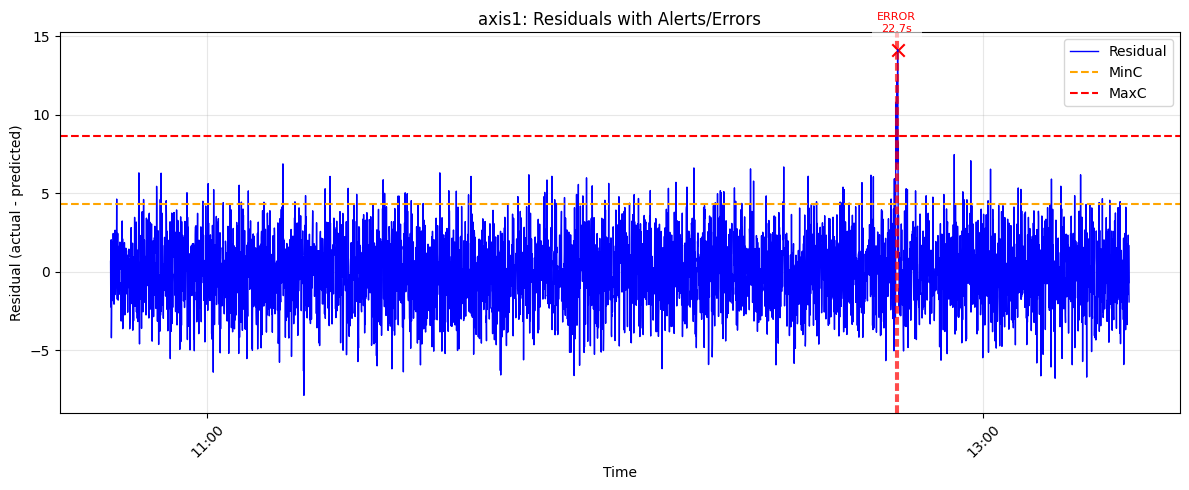

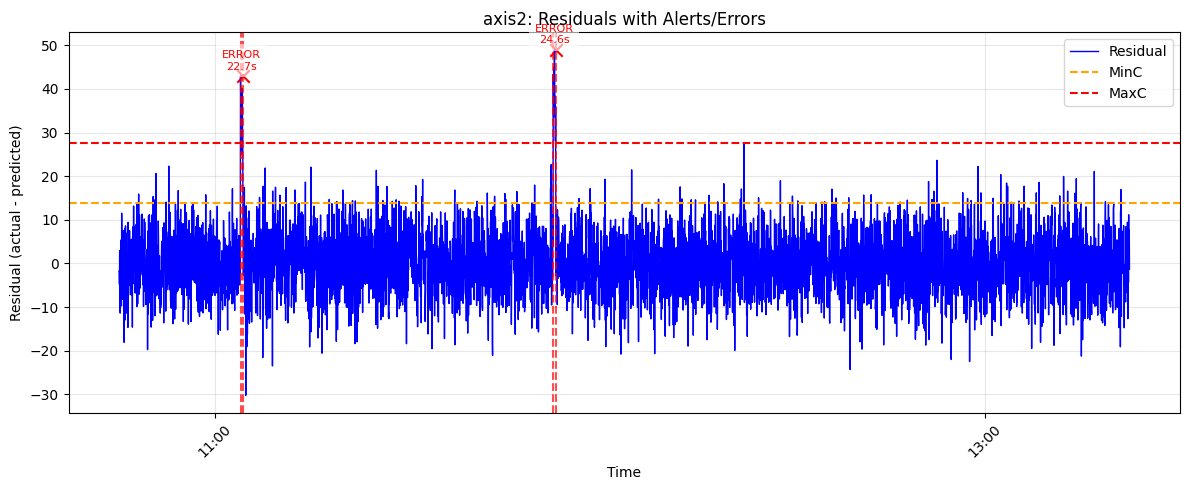

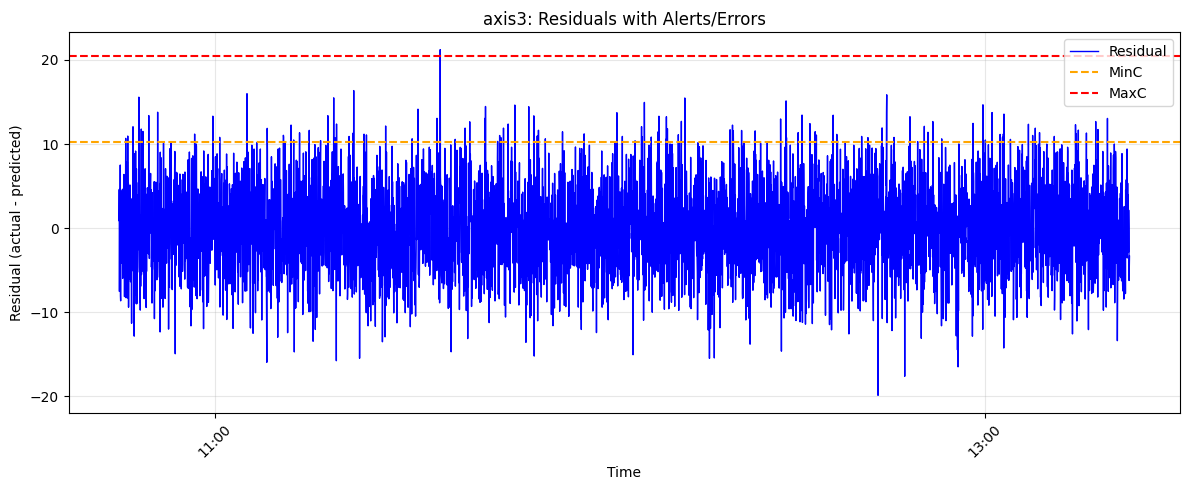

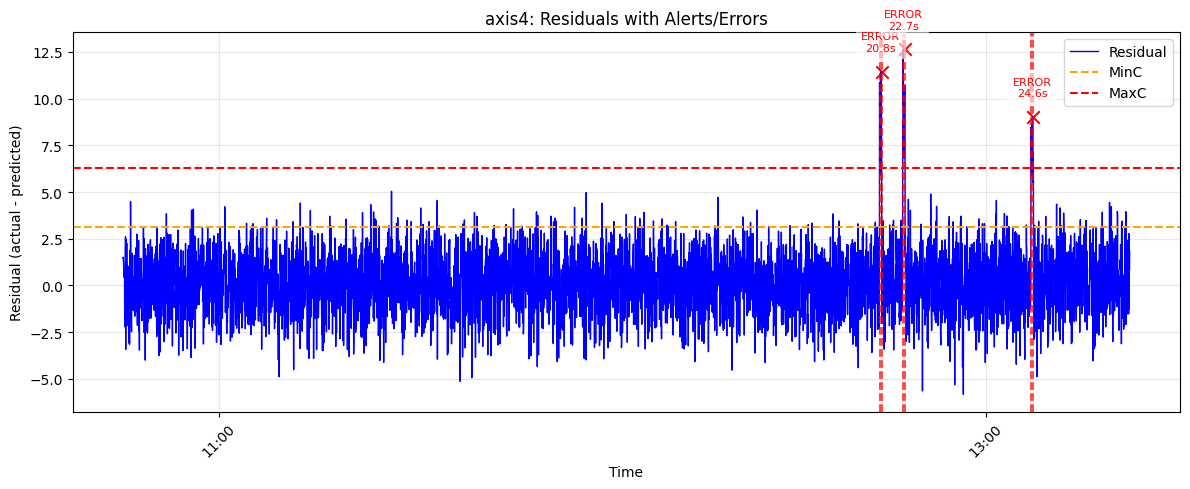

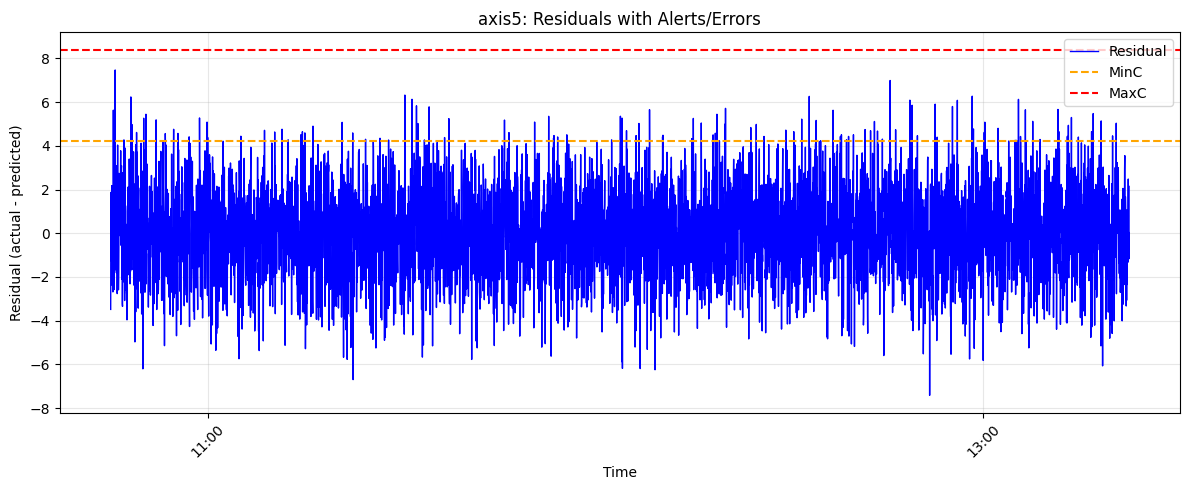

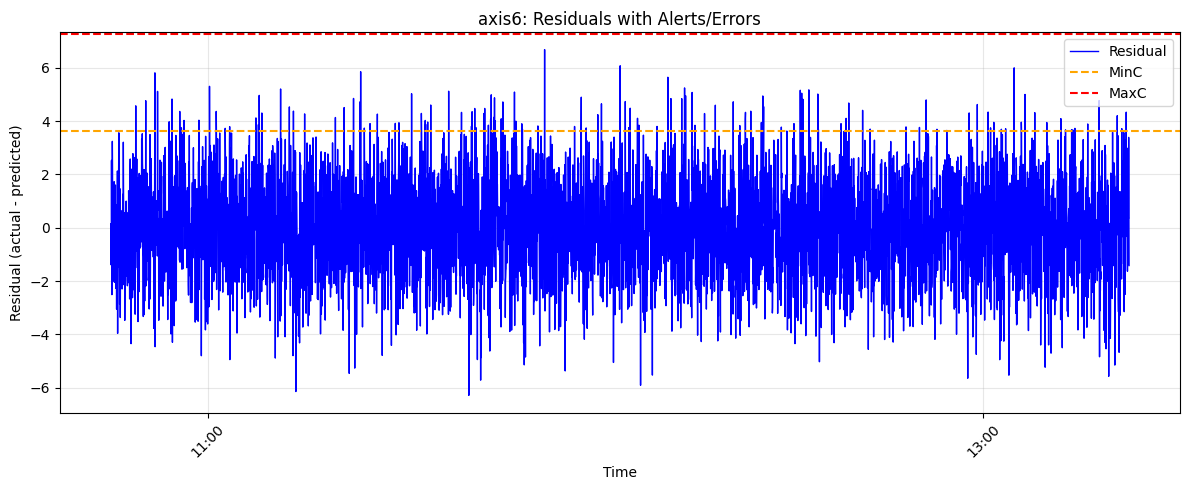

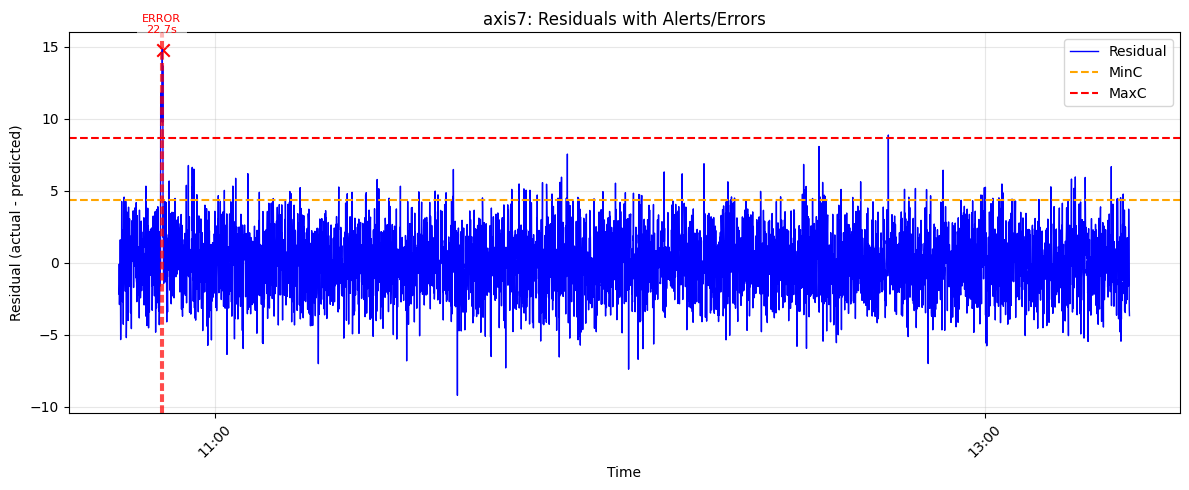

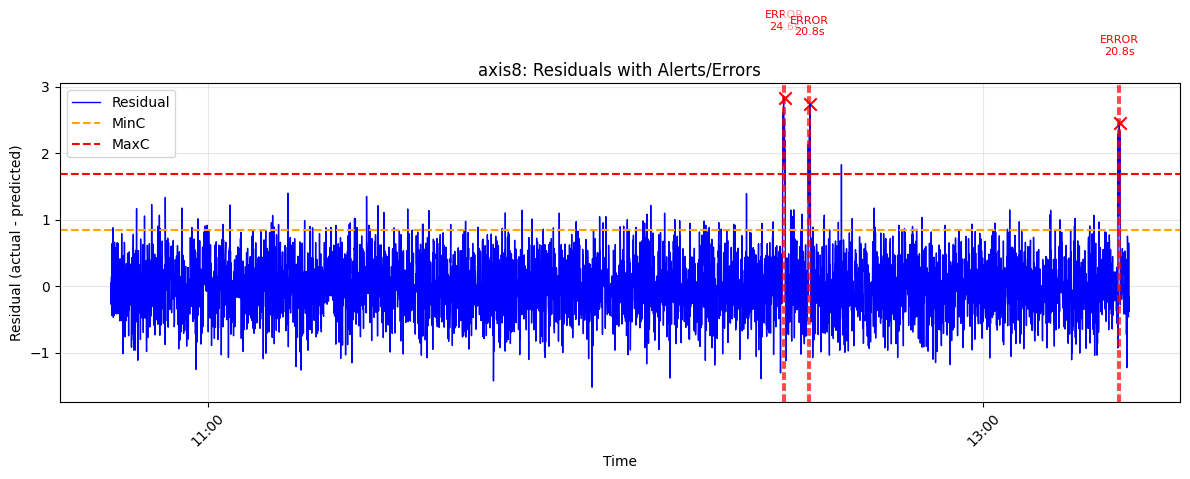

In [15]:
def plot_residuals_with_events(axis, df, residuals_test, MinC, MaxC, events):
    r = residuals_test[axis]
    t = df['time'].values

    plt.figure(figsize=(12,5))
    plt.plot(t, r, color='blue', linewidth=1, label='Residual')
    plt.axhline(MinC[axis], linestyle='--', color='orange', label='MinC')
    plt.axhline(MaxC[axis], linestyle='--', color='red', label='MaxC')

    for ev in events:
        if ev.axis != axis:
            continue
        plt.axvline(df.loc[ev.start_idx, 'time'], color='green' if ev.level=='ALERT' else 'red',
                    linestyle='--', alpha=0.7)
        plt.axvline(df.loc[ev.end_idx, 'time'], color='green' if ev.level=='ALERT' else 'red',
                    linestyle='--', alpha=0.7)
        plt.scatter(df.loc[ev.end_idx, 'time'], ev.peak_residual,
                    color='red' if ev.level=='ERROR' else 'orange', marker='x', s=80)
        mid_idx = ev.start_idx + (ev.end_idx - ev.start_idx)//2
        mid_time = df.loc[mid_idx, 'time']
        plt.text(mid_time, ev.peak_residual + 1,
                 f'{ev.level}\n{ev.duration_sec:.1f}s',
                 color='red' if ev.level=='ERROR' else 'orange',
                 ha='center', va='bottom', fontsize=8,
                 bbox=dict(facecolor='white', alpha=0.6, edgecolor='none'))

    ax = plt.gca()
    ax.xaxis.set_major_locator(mdates.HourLocator(interval=2))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    plt.xticks(rotation=45)
    plt.title(f'{axis}: Residuals with Alerts/Errors')
    plt.xlabel('Time')
    plt.ylabel('Residual (actual - predicted)')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.savefig(f'Data/{axis}_residuals_plot.png')  # Save for README
    plt.show()

# Run for all axes
for axis in AXES:
    plot_residuals_with_events(axis, df_test, residuals_test, MinC, MaxC, events)

## Summary
This notebook implements a predictive maintenance pipeline:
- Connected to Neon.tech DB, pulled training data.
- Fitted linear regression models for axes 1-8.
- Analyzed residuals to set MinC (2*std), MaxC (4*std), T (20 sec).
- Generated synthetic test data with anomalies.
- Simulated streaming by processing in chunks.
- Detected/logged alerts/errors based on thresholds.
- Visualized fits, residuals, and annotated events.

See `Data/` for CSVs and plots. Results align with predictive maintenance: alerts catch early trends, errors flag critical issues.